# Car Price prediction

<img src="https://whatcar.vn/media/2018/09/car-lot-940x470.jpg"/>

## Прогнозирование стоимости автомобиля по характеристикам
*Этот ноутбук является шаблоном (Baseline) к текущему соревнованию и не служит готовым решением!*   
Вы можете использовать его как основу для построения своего решения.


> **Baseline** создается больше как шаблон, где можно посмотреть, как происходит обращение с входящими данными и что нужно получить на выходе. При этом ML начинка может быть достаточно простой. Это помогает быстрее приступить к самому ML, а не тратить ценное время на инженерные задачи. 
Также baseline является хорошей опорной точкой по метрике. Если наше решение хуже baseline -  мы явно делаем что-то не так и стоит попробовать другой путь) 

## В baseline мы сделаем следующее:
* Построим "наивную"/baseline модель, предсказывающую цену по модели и году выпуска (с ней будем сравнивать другие модели)
* Обработаем и отнормируем признаки
* Сделаем первую модель на основе градиентного бустинга с помощью CatBoost
* Сделаем вторую модель на основе нейронных сетей и сравним результаты
* Сделаем multi-input нейронную сеть для анализа табличных данных и текста одновременно
* Добавим в multi-input сеть обработку изображений
* Осуществим ансамблирование градиентного бустинга и нейронной сети (усреднение их предсказаний)

In [1]:
!pip install -q tensorflow==2.3

You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [2]:
#аугментации изображений
!pip install albumentations -q

You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [3]:
#обработка текста
!pip install pymorphy2
!pip install pymorphy2-dicts

     |████████████████████████████████| 55 kB 778 kB/s eta 0:00:01
     |████████████████████████████████| 8.2 MB 1.7 MB/s eta 0:00:01
You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.
     |████████████████████████████████| 7.1 MB 880 kB/s eta 0:00:01
You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [4]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import random
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import sys
import PIL
import cv2
import re
import pymorphy2
import nltk

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

from catboost import CatBoostRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

# # keras
import tensorflow as tf
import tensorflow.keras.layers as L
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
import albumentations

# plt
import matplotlib.pyplot as plt
#увеличим дефолтный размер графиков
from pylab import rcParams
rcParams['figure.figsize'] = 10, 5
#графики в svg выглядят более четкими
%config InlineBackend.figure_format = 'svg' 
%matplotlib inline

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [5]:
print('Python       :', sys.version.split('\n')[0])
print('Numpy        :', np.__version__)
print('Tensorflow   :', tf.__version__)

Python       : 3.7.6 | packaged by conda-forge | (default, Mar 23 2020, 23:03:20) 
Numpy        : 1.18.5
Tensorflow   : 2.3.0


In [6]:
def mape(y_true, y_pred):
    return np.mean(np.abs((y_pred-y_true)/y_true))

In [7]:
# всегда фиксируйте RANDOM_SEED, чтобы ваши эксперименты были воспроизводимы!
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

In [8]:
!pip freeze > requirements.txt

# DATA

Посмотрим на типы признаков:

* bodyType - категориальный
* brand - категориальный
* color - категориальный
* description - текстовый
* engineDisplacement - числовой, представленный как текст
* enginePower - числовой, представленный как текст
* fuelType - категориальный
* mileage - числовой
* modelDate - числовой
* model_info - категориальный
* name - категориальный, желательно сократить размерность
* numberOfDoors - категориальный
* price - числовой, целевой
* productionDate - числовой
* sell_id - изображение (файл доступен по адресу, основанному на sell_id)
* vehicleConfiguration - не используется (комбинация других столбцов)
* vehicleTransmission - категориальный
* Владельцы - категориальный
* Владение - числовой, представленный как текст
* ПТС - категориальный
* Привод - категориальный
* Руль - категориальный

In [9]:
DATA_DIR = '../input/sf-dst-car-price-prediction-part2/'
train = pd.read_csv(DATA_DIR + 'train.csv')
test = pd.read_csv(DATA_DIR + 'test.csv')
sample_submission = pd.read_csv(DATA_DIR + 'sample_submission.csv')

In [10]:
train.head()

,bodyType,brand,color,description,engineDisplacement,enginePower,fuelType,mileage,modelDate,model_info,...,price,productionDate,sell_id,vehicleConfiguration,vehicleTransmission,Владельцы,Владение,ПТС,Привод,Руль
0,седан,BMW,чёрный,Авто на бодром ходу. Все работает отлично. П...,3.0 LTR,272 N12,бензин,245000,2007,5ER,...,599000.0,2007,1099980990,SEDAN AUTOMATIC 3.0,автоматическая,3 или более,NaN,Оригинал,полный,Левый
1,седан,AUDI,серебристый,"Продажа от собственника, второй владелец, ПТС ...",2.8 LTR,204 N12,бензин,183000,2011,A6,...,850000.0,2011,1095836906,SEDAN VARIATOR 2.8,вариатор,2 владельца,8 лет и 6 месяцев,Оригинал,передний,Левый
2,седан,MERCEDES,чёрный,Внимание! Только для клиентов AVILON Автомобил...,3.5 LTR,306 N12,бензин,122733,2009,E_KLASSE,...,1325000.0,2013,1100195530,SEDAN AUTOMATIC 3.5,автоматическая,3 или более,NaN,Оригинал,полный,Левый
3,седан,AUDI,белый,В комплекте зимние колёса. 27.07.2020 Замена п...,2.0 LTR,180 N12,бензин,151000,2011,A6,...,815000.0,2011,1099880662,SEDAN VARIATOR 2.0,вариатор,3 или более,4 года и 9 месяцев,Оригинал,передний,Левый
4,лифтбек,AUDI,белый,"Отличный авто, 2011 года выпуска, кроме передн...",1.8 LTR,160 N12,бензин,140000,2007,A5,...,810000.0,2011,1083244610,LIFTBACK VARIATOR 1.8,вариатор,3 или более,2 года и 9 месяцев,Оригинал,передний,Левый


In [11]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6682 entries, 0 to 6681
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   bodyType              6682 non-null   object 
 1   brand                 6682 non-null   object 
 2   color                 6682 non-null   object 
 3   description           6682 non-null   object 
 4   engineDisplacement    6682 non-null   object 
 5   enginePower           6682 non-null   object 
 6   fuelType              6682 non-null   object 
 7   mileage               6682 non-null   int64  
 8   modelDate             6682 non-null   int64  
 9   model_info            6682 non-null   object 
 10  name                  6682 non-null   object 
 11  numberOfDoors         6682 non-null   int64  
 12  price                 6682 non-null   float64
 13  productionDate        6682 non-null   int64  
 14  sell_id               6682 non-null   int64  
 15  vehicleConfiguration 

In [12]:
train.nunique()

bodyType                  17
brand                      3
color                     16
description             6147
engineDisplacement        48
enginePower              146
fuelType                   4
mileage                 2900
modelDate                 41
model_info               118
name                     900
numberOfDoors              4
price                   1628
productionDate            38
sell_id                 6682
vehicleConfiguration     288
vehicleTransmission        4
Владельцы                  3
Владение                 173
ПТС                        2
Привод                     3
Руль                       2
dtype: int64

# Model 1: Создадим "наивную" модель 
Эта модель будет предсказывать среднюю цену по модели и году выпуска. 
C ней будем сравнивать другие модели.



In [13]:
# split данных
data_train, data_test = train_test_split(train, test_size=0.15, shuffle=True, random_state=RANDOM_SEED)

In [14]:
# Наивная модель
predicts = []
for index, row in pd.DataFrame(data_test[['model_info', 'productionDate']]).iterrows():
    query = f"model_info == '{row[0]}' and productionDate == '{row[1]}'"
    predicts.append(data_train.query(query)['price'].median())

# заполним не найденные совпадения
predicts = pd.DataFrame(predicts)
predicts = predicts.fillna(predicts.median())

# округлим
predicts = (predicts // 1000) * 1000

#оцениваем точность
print(f"Точность наивной модели по метрике MAPE: {(mape(data_test['price'], predicts.values[:, 0]))*100:0.2f}%")

Точность наивной модели по метрике MAPE: 19.88%


# EDA

Проведем быстрый анализ данных для того, чтобы понимать, сможет ли с этими данными работать наш алгоритм.

Посмотрим, как выглядят распределения числовых признаков:

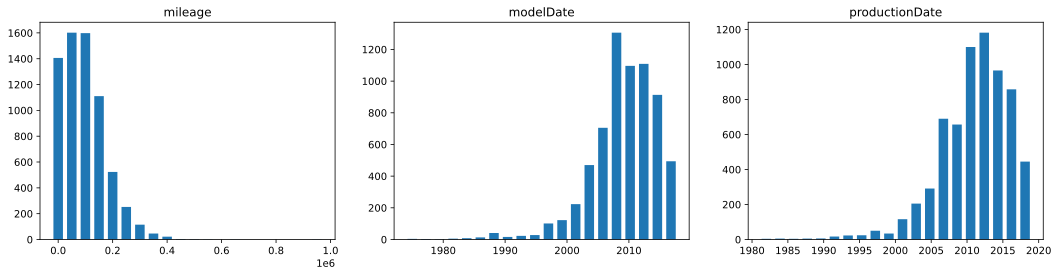

In [15]:
#посмотрим, как выглядят распределения числовых признаков
def visualize_distributions(titles_values_dict):
  columns = min(3, len(titles_values_dict))
  rows = (len(titles_values_dict) - 1) // columns + 1
  fig = plt.figure(figsize = (columns * 6, rows * 4))
  for i, (title, values) in enumerate(titles_values_dict.items()):
    hist, bins = np.histogram(values, bins = 20)
    ax = fig.add_subplot(rows, columns, i + 1)
    ax.bar(bins[:-1], hist, width = (bins[1] - bins[0]) * 0.7)
    ax.set_title(title)
  plt.show()

visualize_distributions({
    'mileage': train['mileage'].dropna(),
    'modelDate': train['modelDate'].dropna(),
    'productionDate': train['productionDate'].dropna()
})

Итого:
* CatBoost сможет работать с признаками и в таком виде, но для нейросети нужны нормированные данные.

# PreProc Tabular Data

In [16]:
# #используем все текстовые признаки как категориальные без предобработки
# categorical_features = ['bodyType', 'brand', 'color', 'engineDisplacement', 'enginePower', 'fuelType', 'model_info', 'name',
#   'numberOfDoors', 'vehicleTransmission', 'Владельцы', 'Владение', 'ПТС', 'Привод', 'Руль']

# #используем все числовые признаки
# numerical_features = ['mileage', 'modelDate', 'productionDate']

In [17]:
# ВАЖНО! дря корректной обработки признаков объединяем трейн и тест в один датасет
train['sample'] = 1 # помечаем где у нас трейн
test['sample'] = 0 # помечаем где у нас тест
test['price'] = 0 # в тесте у нас нет значения price, мы его должны предсказать, поэтому пока просто заполняем нулями

data = test.append(train, sort=False).reset_index(drop=True) # объединяем
print(train.shape, test.shape, data.shape)

(6682, 23) (1671, 23) (8353, 23)


In [18]:
### Функции для преобразования признаков


def engineDisplacement(row):
    row = str(row)
    engine = re.findall('\d\.\d', row)
    if engine == []:
        return None
    return float(engine[0])

### Делаем из строкового признака "Срок владения" числовой с плавающей точкой(количество лет)
def owner_age(row):
    age = 0.
    if type(row) == str:
        nums  =  re.findall('(\d+)', row)
        month =  re.findall('месяц', row)
    else:
        return 0.1
    
    if len(nums) == 2:
        age = int(nums[0])*12 + int(nums[1])
    elif len(nums) == 1:         
        if len(month) == 0:
            age = int(nums[0])*12
        else:
            age = int(nums[0])
    else:
        return 0.1
          
    return age/12.
                        
### Делаем из строкового признака "Количество владельцев" числовой 
def owners_count(row):
    if type(row) == str:
        return (int)(row[0])
    else:
        return -1

### Делаем из строкового признака "Объем двигателя" числовой с плавающей точкой
def engine_displacement(row):
    row = row.split(' ')[0]
    if row == 'undefined':
        return 0
    return (float)(row)

In [19]:
train.loc[train['engineDisplacement'] == 'undefined LTR', 'name']

2296    S Electro AT (136 кВт)
3725      Electro AT (126 кВт)
3726      Electro AT (126 кВт)
5862      Electro AT (126 кВт)
6283      Electro AT (126 кВт)
Name: name, dtype: object

In [20]:
pts_dict = {'Дубликат': 0, 'Оригинал': 1,}
data['ПТС'] = data['ПТС'].map(pts_dict)

# wheel_dict = {'Правый': 0, 'Левый': 1,}
# data['Руль'] = data['Руль'].map(wheel_dict)


data.loc[data['engineDisplacement'] == 'undefined LTR', 'engineDisplacement'] = '1.3 LTR'  ## "электро"
data['engineDisplacement'] = data['engineDisplacement'].str.split().apply(lambda s: s[0])
data['engineDisplacement'] = data['engineDisplacement'].apply(lambda s: float(s))
# data['engineDisplacement'] = data['engineDisplacement']*1000
# data['engineDisplacement'] = data['engineDisplacement'].apply(lambda s: int(s))

data['enginePower'] = data['enginePower'].apply(lambda x : (int)(x.split(' ')[0]))
data['modelDate'] = 2021 - data['modelDate']
data.loc[data['model_info'] == '100', 'model_info'] = 'S4'
data.loc[data['model_info'] == 'COUPE', 'model_info'] = 'S2'
data.loc[data['model_info'] == 'None', 'model_info'] = 'C_KLASSE_AMG'
data['productionDate'] = 2021 - data['productionDate']
data['Владельцы'] = data['Владельцы'].apply(lambda x : owners_count(x))
data['Владение'] = data['Владение'].apply(lambda x : owner_age(x))


In [21]:
data

,bodyType,brand,color,description,engineDisplacement,enginePower,fuelType,mileage,modelDate,model_info,...,sell_id,vehicleConfiguration,vehicleTransmission,Владельцы,Владение,ПТС,Привод,Руль,sample,price
0,универсал 5 дв.,MERCEDES,чёрный,Всем привет!\n\nПродам эксклюзивный проект 124...,3.0,220,бензин,350000,37,W124,...,1099427284,WAGON_5_DOORS AUTOMATIC 3.0,автоматическая,3,6.250000,1,задний,Левый,0,0.0
1,купе,BMW,белый,Продаю любимейшую тачилу.. Обвес и тюнинг Hamm...,3.0,313,дизель,15000,10,6ER,...,1096405886,COUPE AUTOMATIC 3.0,автоматическая,1,6.500000,1,полный,Левый,0,0.0
2,купе,BMW,пурпурный,"Машина тут продаётся не в первый раз, НО! Толь...",2.5,218,бензин,166600,16,3ER,...,1100195294,COUPE AUTOMATIC 2.5,автоматическая,3,0.100000,1,полный,Левый,0,0.0
3,седан,BMW,белый,"Автомобиль в отличном состоянии, весь в родной...",2.0,136,бензин,147000,16,3ER,...,1099827282,SEDAN AUTOMATIC 2.0,автоматическая,2,0.100000,1,задний,Левый,0,0.0
4,седан,BMW,чёрный,Немка! с бесключивым доступом и камерой заднег...,2.0,190,дизель,24000,5,5ER,...,1100076198,SEDAN AUTOMATIC 2.0,автоматическая,1,0.100000,1,полный,Левый,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8348,седан,BMW,серый,Продаётся любимый автомобиль! За годы эксплуат...,2.0,150,бензин,232777,16,3ER,...,1100036650,SEDAN AUTOMATIC 2.0,автоматическая,3,0.100000,1,задний,Левый,1,550000.0
8349,седан,BMW,чёрный,Куплена у официального дилера в 2017 г. \n\nТр...,2.0,190,дизель,33700,8,5ER,...,1090506038,SEDAN AUTOMATIC 2.0,автоматическая,3,2.166667,1,задний,Левый,1,1900000.0
8350,седан,BMW,белый,Торг на месте. Все работает. Сборка немецкая. ...,2.0,143,бензин,200000,13,3ER,...,1095155628,SEDAN AUTOMATIC 2.0,автоматическая,3,2.166667,1,задний,Левый,1,530000.0
8351,седан,AUDI,чёрный,Автомобиль в отличном состоянии.\n3-из Авто в ...,3.0,310,бензин,72000,8,A8,...,1099625256,SEDAN AUTOMATIC 3.0,автоматическая,3,0.100000,1,полный,Левый,1,1970000.0


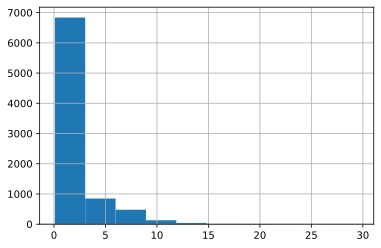

In [22]:
data['Владение'].hist()

In [23]:
#используем все текстовые признаки как категориальные без предобработки
categorical_features = ['bodyType', 'brand', 'color', 'fuelType', 'model_info',
  'numberOfDoors', 'vehicleTransmission', 'Владельцы' , 'ПТС', 'Привод']

#используем все числовые признаки
numerical_features = ['mileage', 'modelDate', 'productionDate', 
    'engineDisplacement', 'enginePower', 'Владение']

In [25]:
def preproc_data(df_input):
    '''includes several functions to pre-process the predictor data.'''
    
    df_output = df_input.copy()
    
    # ################### 1. Предобработка ############################################################## 
    # убираем не нужные для модели признаки
    df_output.drop(['description','sell_id','vehicleConfiguration', 'name', 'Руль'], axis = 1, inplace=True)
    
    # ################### Numerical Features ############################################################## 
    # Далее заполняем пропуски
    for column in numerical_features:
        df_output[column].fillna(df_output[column].median(), inplace=True)
    # тут ваш код по обработке N
    # ....
    
    ###
    ### Сделаем распределения числовых данных более "нормальными"
    for column in numerical_features:
        df_output[column] = np.log10(df_output[column])

    # Нормализация данных
    scaler = MinMaxScaler()
    for column in numerical_features:
        df_output[column] = scaler.fit_transform(df_output[[column]])[:,0]
    
    
    # ################### Categorical Features ############################################################## 
    # Label Encoding
    for column in categorical_features:
        df_output[column] = df_output[column].astype('category').cat.codes
        
    # One-Hot Encoding: в pandas есть готовая функция - get_dummies.
    df_output = pd.get_dummies(df_output, columns=categorical_features, dummy_na=False)
    
    
    # тут ваш код не Encoding фитчей
    # ....
    
    
    # ################### Feature Engineering ####################################################
    # тут ваш код не генерацию новых фитчей
    # ....
    
    
    # ################### Clean #################################################### 
    # убираем признаки которые еще не успели обработать, 
    #df_output.drop(['vehicleConfiguration'], axis = 1, inplace=True)
    
    return df_output

In [26]:
data.name

0                    300 3.0 AT (220 л.с.)
1       640d xDrive 3.0d AT (313 л.с.) 4WD
2              325xi 2.5 AT (218 л.с.) 4WD
3                   318i 2.0 AT (136 л.с.)
4       520d xDrive 2.0d AT (190 л.с.) 4WD
                       ...                
8348                320i 2.0 AT (150 л.с.)
8349               520d 2.0d AT (190 л.с.)
8350                318i 2.0 AT (143 л.с.)
8351            Long 3.0 AT (310 л.с.) 4WD
8352             Pullman 6.0 AT (394 л.с.)
Name: name, Length: 8353, dtype: object

In [27]:
# Запускаем и проверяем, что получилось
df_preproc = preproc_data(data)
df_preproc.sample(10)

,engineDisplacement,enginePower,mileage,modelDate,productionDate,Владение,sample,price,bodyType_0,bodyType_1,...,vehicleTransmission_3,Владельцы_0,Владельцы_1,Владельцы_2,Владельцы_3,ПТС_0,ПТС_1,Привод_0,Привод_1,Привод_2
7399,0.467888,0.529985,0.838231,0.389193,0.489076,0.688517,1,1590000.0,0,1,...,0,0,1,0,0,0,1,0,0,1
4273,0.467888,0.529985,0.775535,0.430677,0.439310,0.579211,1,3100000.0,0,1,...,0,0,1,0,0,0,1,0,0,1
3362,0.918742,0.919650,0.790060,0.430677,0.489076,0.031049,1,3750000.0,0,0,...,0,0,0,0,1,0,1,0,0,1
2794,0.648598,0.529985,0.849485,0.500000,0.628510,0.031049,1,1990000.0,0,0,...,1,0,0,0,1,0,1,0,0,1
5378,0.467888,0.477709,0.862198,0.430677,0.489076,0.031049,1,1285000.0,0,0,...,0,0,0,0,1,0,1,0,0,1
5902,0.776813,0.900097,0.807309,0.467268,0.567601,0.031049,1,3399999.0,0,0,...,0,0,1,0,0,0,1,0,0,1
1454,0.648598,0.649551,0.787059,0.467268,0.489076,0.031049,0,0.0,0,0,...,0,0,0,1,0,0,1,0,0,1
2476,0.567340,0.477709,0.873217,0.604531,0.700125,0.636511,1,700000.0,0,0,...,0,0,0,0,1,1,0,1,0,0
743,0.368437,0.191371,0.846530,0.604531,0.654526,0.031049,0,0.0,0,0,...,0,0,0,0,1,0,1,1,0,0
1168,0.918742,0.887119,0.759384,0.467268,0.531153,0.031049,0,0.0,0,1,...,0,0,0,0,1,0,1,0,0,1


In [28]:
df_preproc.describe()

,engineDisplacement,enginePower,mileage,modelDate,productionDate,Владение,sample,price,bodyType_0,bodyType_1,...,vehicleTransmission_3,Владельцы_0,Владельцы_1,Владельцы_2,Владельцы_3,ПТС_0,ПТС_1,Привод_0,Привод_1,Привод_2
count,8353.000000,8353.000000,8353.000000,8353.000000,8353.000000,8353.000000,8353.000000,8.353000e+03,8353.000000,8353.000000,...,8353.000000,8353.000000,8353.000000,8353.000000,8353.000000,8353.000000,8353.000000,8353.000000,8353.000000,8353.000000
mean,0.585791,0.514499,0.818091,0.489008,0.551507,0.232476,0.799952,1.519804e+06,0.000599,0.346702,...,0.143781,0.000120,0.302406,0.301089,0.396385,0.105232,0.894768,0.270442,0.104873,0.624686
std,0.156392,0.170485,0.093948,0.157638,0.172825,0.287274,0.400060,1.873130e+06,0.024460,0.475948,...,0.350888,0.010942,0.459328,0.458759,0.489175,0.306870,0.306870,0.444215,0.306407,0.484233
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.467888,0.401796,0.795443,0.389193,0.439310,0.031049,1.000000,4.600000e+05,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000
50%,0.617849,0.503641,0.840484,0.500000,0.567601,0.031049,1.000000,1.030000e+06,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000
75%,0.648598,0.629523,0.870489,0.604531,0.678276,0.526393,1.000000,1.900000e+06,0.000000,1.000000,...,0.000000,0.000000,1.000000,1.000000,1.000000,0.000000,1.000000,1.000000,0.000000,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,2.390000e+07,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


## Split data

In [29]:
# Теперь выделим тестовую часть
train_data = df_preproc.query('sample == 1').drop(['sample'], axis=1)
test_data = df_preproc.query('sample == 0').drop(['sample'], axis=1)

y = train_data.price.values     # наш таргет
X = train_data.drop(['price'], axis=1)
X_sub = test_data.drop(['price'], axis=1)

In [30]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1671 entries, 0 to 1670
Columns: 184 entries, engineDisplacement to Привод_2
dtypes: float64(7), uint8(177)
memory usage: 393.3 KB


# Model 2: CatBoostRegressor

In [31]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, shuffle=True, random_state=RANDOM_SEED)

In [32]:
model = CatBoostRegressor(iterations = 5000,
                          #depth=10,
                          #learning_rate = 0.5,
                          random_seed = RANDOM_SEED,
                          eval_metric='MAPE',
                          custom_metric=['RMSE', 'MAE'],
                          od_wait=500,
                          #task_type='GPU',
                         )
model.fit(X_train, y_train,
         eval_set=(X_test, y_test),
         verbose_eval=100,
         use_best_model=True,
         #plot=True
         )

Learning rate set to 0.023474
0:	learn: 0.9862493	test: 1.0105768	best: 1.0105768 (0)	total: 52.9ms	remaining: 4m 24s
100:	learn: 0.2984603	test: 0.2979261	best: 0.2979261 (100)	total: 360ms	remaining: 17.5s
200:	learn: 0.2314664	test: 0.2277689	best: 0.2277689 (200)	total: 655ms	remaining: 15.6s
300:	learn: 0.1965994	test: 0.1950837	best: 0.1950837 (300)	total: 936ms	remaining: 14.6s
400:	learn: 0.1789746	test: 0.1794352	best: 0.1794352 (400)	total: 1.23s	remaining: 14.1s
500:	learn: 0.1721555	test: 0.1746792	best: 0.1746389 (491)	total: 1.51s	remaining: 13.6s
600:	learn: 0.1662768	test: 0.1694125	best: 0.1694125 (600)	total: 1.79s	remaining: 13.1s
700:	learn: 0.1574178	test: 0.1613424	best: 0.1613424 (700)	total: 2.08s	remaining: 12.8s
800:	learn: 0.1513108	test: 0.1569352	best: 0.1569352 (800)	total: 2.41s	remaining: 12.6s
900:	learn: 0.1460360	test: 0.1533871	best: 0.1533871 (900)	total: 2.87s	remaining: 13.1s
1000:	learn: 0.1418058	test: 0.1500272	best: 0.1500272 (1000)	total: 3.2

In [33]:
test_predict_catboost = model.predict(X_test)
print(f"TEST mape: {(mape(y_test, test_predict_catboost))*100:0.2f}%")

TEST mape: 12.79%


TEST mape: 13.23% #default

TEST mape: 13.23% #log10

TEST mape: 12.48% #EDA

TEST mape: 12.52% #without 'name'

TEST mape: 12.79% #without 


### Submission

In [34]:
sub_predict_catboost = model.predict(X_sub)
sample_submission['price'] = sub_predict_catboost
sample_submission.to_csv('catboost_submission.csv', index=False)

# Model 3: Tabular NN

Построим обычную сеть:

In [35]:
X_train.head(5)

,engineDisplacement,enginePower,mileage,modelDate,productionDate,Владение,bodyType_0,bodyType_1,bodyType_2,bodyType_3,...,vehicleTransmission_3,Владельцы_0,Владельцы_1,Владельцы_2,Владельцы_3,ПТС_0,ПТС_1,Привод_0,Привод_1,Привод_2
7320,0.957522,0.887119,0.862682,0.581508,0.628510,0.803543,0,0,0,0,...,0,0,1,0,0,0,1,1,0,0
8037,0.467888,0.529985,0.720170,0.284662,0.299875,0.031049,0,1,0,0,...,0,0,1,0,0,0,1,0,0,1
4681,0.663211,0.547896,0.854462,0.664849,0.739185,0.031049,0,0,0,0,...,0,0,0,0,1,0,1,0,0,1
6014,0.420931,0.401796,0.919752,0.625965,0.720353,0.744101,0,0,0,0,...,0,0,0,0,1,0,1,1,0,0
3649,0.648598,0.639649,0.850062,0.500000,0.567601,0.741931,0,0,0,0,...,0,0,1,0,0,0,1,0,0,1


## Simple Dense NN

In [36]:
model = Sequential()
model.add(L.Dense(512, input_dim=X_train.shape[1], activation="relu")) #, kernel_regularizer=regularizers.l1_l2(l1=0.000000001, l2=0.000000001)
model.add(L.Dropout(0.5))
model.add(L.Dense(256, activation="relu")) #kernel_regularizer=regularizers.l1_l2(l1=0.000000001, l2=0.000000001), 
model.add(L.Dropout(0.5))
model.add(L.Dense(1, activation="linear"))

In [37]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 512)               94208     
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               131328    
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 257       
Total params: 225,793
Trainable params: 225,793
Non-trainable params: 0
_________________________________________________________________


In [38]:
# Compile model
optimizer = tf.keras.optimizers.Adam(0.01)
model.compile(loss='MAPE',optimizer=optimizer, metrics=['MAPE'])

In [39]:
checkpoint = ModelCheckpoint('../working/best_model.hdf5' , monitor=['val_MAPE'], verbose=0  , mode='min')
earlystop = EarlyStopping(monitor='val_MAPE', patience=50, restore_best_weights=True,)
callbacks_list = [checkpoint, earlystop]

### Fit

In [40]:
%%time
history = model.fit(X_train, y_train,
                    batch_size=512,
                    epochs=500, # фактически мы обучаем пока EarlyStopping не остановит обучение
                    validation_data=(X_test, y_test),
                    callbacks=callbacks_list,
                    verbose=0,
                   )

CPU times: user 38.5 s, sys: 5.03 s, total: 43.6 s
Wall time: 41.1 s


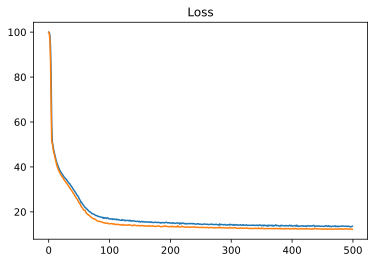

In [41]:
plt.title('Loss')
plt.plot(history.history['MAPE'], label='train')
plt.plot(history.history['val_MAPE'], label='test')
plt.show();

In [42]:
model.load_weights('../working/best_model.hdf5')
model.save('../working/nn_1.hdf5')

In [43]:
test_predict_nn1 = model.predict(X_test)
print(f"TEST mape: {(mape(y_test, test_predict_nn1[:,0]))*100:0.2f}%")

TEST mape: 12.33%


TEST mape: 13.58% #DEFAULT
 
TEST mape: 13.65% #regularizers.L1_L2

TEST mape: 12.55% #

In [44]:
sub_predict_nn1 = model.predict(X_sub)
sample_submission['price'] = sub_predict_nn1[:,0]
sample_submission.to_csv('nn1_submission.csv', index=False)

Рекомендации для улучшения Model 3:    
* В нейросеть желательно подавать данные с распределением, близким к нормальному, поэтому от некоторых числовых признаков имеет смысл взять логарифм перед нормализацией. Пример:
`modelDateNorm = np.log(2020 - data['modelDate'])`
Статья по теме: https://habr.com/ru/company/ods/blog/325422

* Извлечение числовых значений из текста:
Парсинг признаков 'engineDisplacement', 'enginePower', 'Владение' для извлечения числовых значений.

* Cокращение размерности категориальных признаков
Признак name 'name' содержит данные, которые уже есть в других столбцах ('enginePower', 'engineDisplacement', 'vehicleTransmission'), поэтому эти данные можно удалить. Затем следует еще сильнее сократить размерность, например, выделив наличие xDrive в качестве отдельного признака.

# Model 4: NLP + Multiple Inputs

In [45]:
data.description

0       Всем привет!\n\nПродам эксклюзивный проект 124...
1       Продаю любимейшую тачилу.. Обвес и тюнинг Hamm...
2       Машина тут продаётся не в первый раз, НО! Толь...
3       Автомобиль в отличном состоянии, весь в родной...
4       Немка! с бесключивым доступом и камерой заднег...
                              ...                        
8348    Продаётся любимый автомобиль! За годы эксплуат...
8349    Куплена у официального дилера в 2017 г. \n\nТр...
8350    Торг на месте. Все работает. Сборка немецкая. ...
8351    Автомобиль в отличном состоянии.\n3-из Авто в ...
8352    Удлиненный заводской Pullman на базе W140 (воо...
Name: description, Length: 8353, dtype: object

In [46]:
# TOKENIZER
# The maximum number of words to be used. (most frequent)
MAX_WORDS = 100000
# Max number of words in each complaint.
MAX_SEQUENCE_LENGTH = 256

In [50]:
from nltk.corpus import stopwords
nltk.download("stopwords")
russian_stopwords = stopwords.words("russian")
morph = pymorphy2.MorphAnalyzer()
data2 = data.copy()

patterns = "[A-Za-z0-9!#$%&'()*+,./:;<=>?@[\]^_`{|}~—\"\-]+●•✅☑️☛"

def lemmatize(row):
    doc = re.sub(patterns, ' ', row)
    tokens = []
    for token in row.split():
        token = token.strip()
        token = morph.normal_forms(token)[0]
        if token not in russian_stopwords:
            tokens.append(token)
    return ' '.join(tokens)

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [51]:
#data['description'] = data2.apply(lambda data2: lemmatize(data2.description), axis=1)

In [52]:
data.description.head(10).apply(lemmatize)

0    весь привет! продать эксклюзивный проект 124 у...
1    продавать любимый тачилу.. обвес тюнинг hamman...
2    машина продаваться первый раз, но! что: перебр...
3    автомобиль отличный состоянии, весь родный кра...
4    немка! бесключивый доступ камера задний вида. ...
5    добрый день, продавать свой автомобиль. переку...
6    внимание! клиент avilon автомобиль пробег пред...
7    шикарный авто, салон побояться это слово идеал...
8    продавать ауди а5, машина 2014 год выпуска, ку...
9    [smart] оригинал птс, факт владелец, авто заре...
Name: description, dtype: object

In [53]:
data.description.head(10)

0    Всем привет!\n\nПродам эксклюзивный проект 124...
1    Продаю любимейшую тачилу.. Обвес и тюнинг Hamm...
2    Машина тут продаётся не в первый раз, НО! Толь...
3    Автомобиль в отличном состоянии, весь в родной...
4    Немка! с бесключивым доступом и камерой заднег...
5    Добрый день, продаю свой автомобиль. Перекупам...
6    Внимание! Только для клиентов AVILON Автомобил...
7    Шикарный авто, а салон не побоюсь этого слова ...
8    Продаю Ауди А5, машина 2014 года выпуска, купл...
9    [Smart]\nОригинал ПТС, По факту один владелец,...
Name: description, dtype: object

In [54]:
data.description = data.description.apply(lemmatize)

In [55]:
# split данных
text_train = data.description.iloc[X_train.index]
text_test = data.description.iloc[X_test.index]
text_sub = data.description.iloc[X_sub.index]

### Tokenizer

In [56]:
%%time
tokenize = Tokenizer(num_words=MAX_WORDS)
tokenize.fit_on_texts(data.description)

CPU times: user 1.25 s, sys: 0 ns, total: 1.25 s
Wall time: 1.25 s


In [57]:
#tokenize.word_index

In [58]:
%%time
text_train_sequences = sequence.pad_sequences(tokenize.texts_to_sequences(text_train), maxlen=MAX_SEQUENCE_LENGTH)
text_test_sequences = sequence.pad_sequences(tokenize.texts_to_sequences(text_test), maxlen=MAX_SEQUENCE_LENGTH)
text_sub_sequences = sequence.pad_sequences(tokenize.texts_to_sequences(text_sub), maxlen=MAX_SEQUENCE_LENGTH)

print(text_train_sequences.shape, text_test_sequences.shape, text_sub_sequences.shape, )

(5679, 256) (1003, 256) (1671, 256)
CPU times: user 1.26 s, sys: 0 ns, total: 1.26 s
Wall time: 1.26 s


In [59]:
# вот так теперь выглядит наш текст
print(text_train.iloc[6])
print(text_train_sequences[6])

. • автомобиль проверить 110 пункт • автокредит специальный ставка 13,7% ауди центр север, официальный дилер audi, входящий группа компания рольф являться крупный дилер европе, предлагать ряд услуга покупка продажа автомобиль пробегом. протяжение многий год наш дилерский центр являться лидер продажа автомобиль пробег среди весь дилер audi россия предоставлять клиент самый большой выбор автомобиль пробег audi марок. каждый автомобиль проходить тщательный диагностик подготовку, гарантировать находиться отличный состоянии. убедиться правильный выборе, возможность пройти тест-драйв ― ознакомительный поездка интересовать автомобиле. смочь ознакомиться автомобиль выходить дом – наш менеджер провести online презентация видеозвонок показать выбрать автомобиль. также ауди центр север представлять уникальный предложение кредитование автомобиль пробег индивидуальный условиях. специалист компания подобрать хороший условие кредитования. 6 000 проверить автомобиль пробег гарантия 2 год ждать сайт ro

### RNN NLP

In [60]:
model_nlp = Sequential()
model_nlp.add(L.Input(shape=MAX_SEQUENCE_LENGTH, name="seq_description"))
model_nlp.add(L.Embedding(len(tokenize.word_index)+1, MAX_SEQUENCE_LENGTH,))
model_nlp.add(L.LSTM(256, return_sequences=True))
model_nlp.add(L.Dropout(0.5))
model_nlp.add(L.LSTM(128,))
model_nlp.add(L.Dropout(0.25))
model_nlp.add(L.Dense(64, activation="relu"))
model_nlp.add(L.Dropout(0.25))

### MLP

In [61]:
model_mlp = Sequential()
model_mlp.add(L.Dense(512, input_dim=X_train.shape[1], activation="relu"))
model_mlp.add(L.Dropout(0.5))
model_mlp.add(L.Dense(256, activation="relu"))
model_mlp.add(L.Dropout(0.5))

### Multiple Inputs NN

In [62]:
combinedInput = L.concatenate([model_nlp.output, model_mlp.output])
# being our regression head
head = L.Dense(64, activation="relu")(combinedInput)
head = L.Dense(1, activation="linear")(head)

model = Model(inputs=[model_nlp.input, model_mlp.input], outputs=head)

In [63]:
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
seq_description (InputLayer)    [(None, 256)]        0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 256, 256)     8128256     seq_description[0][0]            
__________________________________________________________________________________________________
lstm (LSTM)                     (None, 256, 256)     525312      embedding[0][0]                  
__________________________________________________________________________________________________
dropout_2 (Dropout)             (None, 256, 256)     0           lstm[0][0]                       
_______________________________________________________________________________________

### Fit

In [64]:
optimizer = tf.keras.optimizers.Adam(0.01)
model.compile(loss='MAPE',optimizer=optimizer, metrics=['MAPE'])

In [65]:
checkpoint = ModelCheckpoint('../working/best_model.hdf5', monitor=['val_MAPE'], verbose=0, mode='min')
earlystop = EarlyStopping(monitor='val_MAPE', patience=10, restore_best_weights=True,)
callbacks_list = [checkpoint, earlystop]

In [66]:
history = model.fit([text_train_sequences, X_train], y_train,
                    batch_size=512,
                    epochs=500, # фактически мы обучаем пока EarlyStopping не остановит обучение
                    validation_data=([text_test_sequences, X_test], y_test),
                    callbacks=callbacks_list
                   )

Epoch 1/500
12/12 [==============================] - 4s 339ms/step - loss: 99.9830 - MAPE: 99.9830 - val_loss: 99.8041 - val_MAPE: 99.8041
Epoch 2/500
12/12 [==============================] - 3s 277ms/step - loss: 98.2810 - MAPE: 98.2810 - val_loss: 92.3244 - val_MAPE: 92.3244
Epoch 3/500
12/12 [==============================] - 3s 289ms/step - loss: 76.1092 - MAPE: 76.1092 - val_loss: 50.7523 - val_MAPE: 50.7523
Epoch 4/500
12/12 [==============================] - 3s 278ms/step - loss: 53.2162 - MAPE: 53.2162 - val_loss: 48.3078 - val_MAPE: 48.3078
Epoch 5/500
12/12 [==============================] - 3s 284ms/step - loss: 48.2965 - MAPE: 48.2965 - val_loss: 45.5656 - val_MAPE: 45.5656
Epoch 6/500
12/12 [==============================] - 3s 287ms/step - loss: 45.0087 - MAPE: 45.0087 - val_loss: 42.8274 - val_MAPE: 42.8274
Epoch 7/500
12/12 [==============================] - 3s 275ms/step - loss: 42.6138 - MAPE: 42.6138 - val_loss: 40.3048 - val_MAPE: 40.3048
Epoch 8/500
12/12 [========

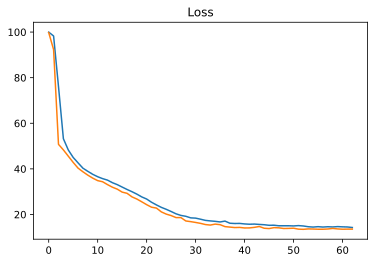

In [67]:
plt.title('Loss')
plt.plot(history.history['MAPE'], label='train')
plt.plot(history.history['val_MAPE'], label='test')
plt.show();

In [68]:
model.load_weights('../working/best_model.hdf5')
model.save('../working/nn_mlp_nlp.hdf5')

In [69]:
test_predict_nn2 = model.predict([text_test_sequences, X_test])
print(f"TEST mape: {(mape(y_test, test_predict_nn2[:,0]))*100:0.2f}%")

TEST mape: 13.58%


TEST mape: 14.01% # default

TEST mape: 12.50%

In [70]:
sub_predict_nn2 = model.predict([text_sub_sequences, X_sub])
sample_submission['price'] = sub_predict_nn2[:,0]
sample_submission.to_csv('nn2_submission.csv', index=False)

Идеи для улучшения NLP части:
* Выделить из описаний часто встречающиеся блоки текста, заменив их на кодовые слова или удалив
* Сделать предобработку текста, например, сделать лемматизацию - алгоритм ставящий все слова в форму по умолчанию (глаголы в инфинитив и т. д.), чтобы токенайзер не преобразовывал разные формы слова в разные числа
Статья по теме: https://habr.com/ru/company/Voximplant/blog/446738/
* Поработать над алгоритмами очистки и аугментации текста

# Model 5: Добавляем картинки

### Data

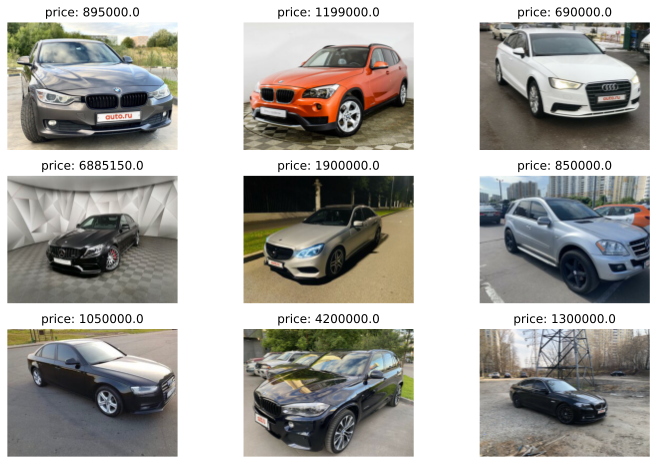

In [71]:
# убедимся, что цены и фото подгрузились верно
plt.figure(figsize = (12,8))

random_image = train.sample(n = 9)
random_image_paths = random_image['sell_id'].values
random_image_cat = random_image['price'].values

for index, path in enumerate(random_image_paths):
    im = PIL.Image.open(DATA_DIR+'img/img/' + str(path) + '.jpg')
    plt.subplot(3, 3, index + 1)
    plt.imshow(im)
    plt.title('price: ' + str(random_image_cat[index]))
    plt.axis('off')
plt.show()

In [72]:
size = (320, 240)

def get_image_array(index):
    images_train = []
    for index, sell_id in enumerate(data['sell_id'].iloc[index].values):
        image = cv2.imread(DATA_DIR + 'img/img/' + str(sell_id) + '.jpg')
        assert(image is not None)
        image = cv2.resize(image, size)
        images_train.append(image)
    images_train = np.array(images_train)
    print('images shape', images_train.shape, 'dtype', images_train.dtype)
    return(images_train)

images_train = get_image_array(X_train.index)
images_test = get_image_array(X_test.index)
images_sub = get_image_array(X_sub.index)

images shape (5679, 240, 320, 3) dtype uint8
images shape (1003, 240, 320, 3) dtype uint8
images shape (1671, 240, 320, 3) dtype uint8


### albumentations

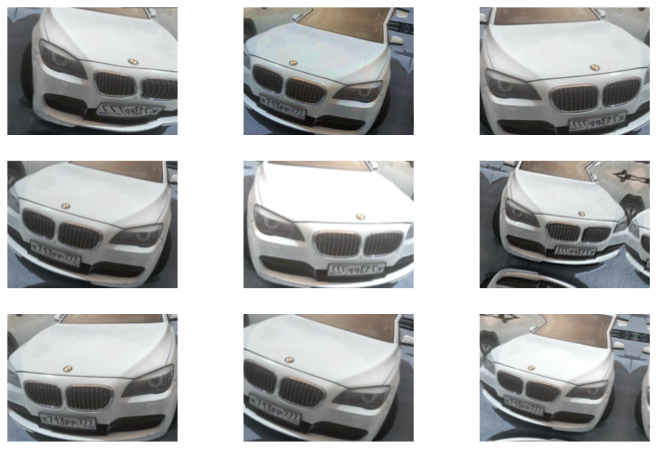

In [73]:
from albumentations import (
    HorizontalFlip, IAAPerspective, ShiftScaleRotate, CLAHE, RandomRotate90,
    Transpose, ShiftScaleRotate, Blur, OpticalDistortion, GridDistortion, HueSaturationValue,
    IAAAdditiveGaussianNoise, GaussNoise, MotionBlur, MedianBlur, IAAPiecewiseAffine,
    IAASharpen, IAAEmboss, RandomBrightnessContrast, Flip, OneOf, Compose
)


#пример взят из официальной документации: https://albumentations.readthedocs.io/en/latest/examples.html
augmentation = Compose([
    HorizontalFlip(),
    OneOf([
        IAAAdditiveGaussianNoise(),
        GaussNoise(),
    ], p=0.2),
    OneOf([
        MotionBlur(p=0.2),
        MedianBlur(blur_limit=3, p=0.1),
        Blur(blur_limit=3, p=0.1),
    ], p=0.2),
    ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.2, rotate_limit=15, p=1),
    OneOf([
        OpticalDistortion(p=0.3),
        GridDistortion(p=0.1),
        IAAPiecewiseAffine(p=0.3),
    ], p=0.2),
    OneOf([
        CLAHE(clip_limit=2),
        IAASharpen(),
        IAAEmboss(),
        RandomBrightnessContrast(),
    ], p=0.3),
    HueSaturationValue(p=0.3),
], p=1)

#пример
plt.figure(figsize = (12,8))
for i in range(9):
    img = augmentation(image = images_train[0])['image']
    plt.subplot(3, 3, i + 1)
    plt.imshow(img)
    plt.axis('off')
plt.show()

In [74]:
def make_augmentations(images):
  print('применение аугментаций', end = '')
  augmented_images = np.empty(images.shape)
  for i in range(images.shape[0]):
    if i % 200 == 0:
      print('.', end = '')
    augment_dict = augmentation(image = images[i])
    augmented_image = augment_dict['image']
    augmented_images[i] = augmented_image
  print('')
  return augmented_images

## tf.data.Dataset
Если все изображения мы будем хранить в памяти, то может возникнуть проблема ее нехватки. Не храните все изображения в памяти целиком!

Метод .fit() модели keras может принимать либо данные в виде массивов или тензоров, либо разного рода итераторы, из которых наиболее современным и гибким является [tf.data.Dataset](https://www.tensorflow.org/guide/data). Он представляет собой конвейер, то есть мы указываем, откуда берем данные и какую цепочку преобразований с ними выполняем. Далее мы будем работать с tf.data.Dataset.

Dataset хранит информацию о конечном или бесконечном наборе кортежей (tuple) с данными и может возвращать эти наборы по очереди. Например, данными могут быть пары (input, target) для обучения нейросети. С данными можно осуществлять преобразования, которые осуществляются по мере необходимости ([lazy evaluation](https://ru.wikipedia.org/wiki/%D0%9B%D0%B5%D0%BD%D0%B8%D0%B2%D1%8B%D0%B5_%D0%B2%D1%8B%D1%87%D0%B8%D1%81%D0%BB%D0%B5%D0%BD%D0%B8%D1%8F)).

`tf.data.Dataset.from_tensor_slices(data)` - создает датасет из данных, которые представляют собой либо массив, либо кортеж из массивов. Деление осуществляется по первому индексу каждого массива. Например, если `data = (np.zeros((128, 256, 256)), np.zeros(128))`, то датасет будет содержать 128 элементов, каждый из которых содержит один массив 256x256 и одно число.

`dataset2 = dataset1.map(func)` - применение функции к датасету; функция должна принимать столько аргументов, каков размер кортежа в датасете 1 и возвращать столько, сколько нужно иметь в датасете 2. Пусть, например, датасет содержит изображения и метки, а нам нужно создать датасет только из изображений, тогда мы напишем так: `dataset2 = dataset.map(lambda img, label: img)`.

`dataset2 = dataset1.batch(8)` - группировка по батчам; если датасет 2 должен вернуть один элемент, то он берет из датасета 1 восемь элементов, склеивает их (нулевой индекс результата - номер элемента) и возвращает.

`dataset.__iter__()` - превращение датасета в итератор, из которого можно получать элементы методом `.__next__()`. Итератор, в отличие от самого датасета, хранит позицию текущего элемента. Можно также перебирать датасет циклом for.

`dataset2 = dataset1.repeat(X)` - датасет 2 будет повторять датасет 1 X раз.

Если нам нужно взять из датасета 1000 элементов и использовать их как тестовые, а остальные как обучающие, то мы напишем так:

`test_dataset = dataset.take(1000)
train_dataset = dataset.skip(1000)`

Датасет по сути неизменен: такие операции, как map, batch, repeat, take, skip никак не затрагивают оригинальный датасет. Если датасет хранит элементы [1, 2, 3], то выполнив 3 раза подряд функцию dataset.take(1) мы получим 3 новых датасета, каждый из которых вернет число 1. Если же мы выполним функцию dataset.skip(1), мы получим датасет, возвращающий числа [2, 3], но исходный датасет все равно будет возвращать [1, 2, 3] каждый раз, когда мы его перебираем.

tf.Dataset всегда выполняется в graph-режиме (в противоположность eager-режиму), поэтому либо преобразования (`.map()`) должны содержать только tensorflow-функции, либо мы должны использовать tf.py_function в качестве обертки для функций, вызываемых в `.map()`. Подробнее можно прочитать [здесь](https://www.tensorflow.org/guide/data#applying_arbitrary_python_logic).

In [75]:
# NLP part
tokenize = Tokenizer(num_words=MAX_WORDS)
tokenize.fit_on_texts(data.description)

In [76]:
def process_image(image):
    return augmentation(image = image.numpy())['image']

def tokenize_(descriptions):
  return sequence.pad_sequences(tokenize.texts_to_sequences(descriptions), maxlen = MAX_SEQUENCE_LENGTH)

def tokenize_text(text):
    return tokenize_([text.numpy().decode('utf-8')])[0]

def tf_process_train_dataset_element(image, table_data, text, price):
    im_shape = image.shape
    [image,] = tf.py_function(process_image, [image], [tf.uint8])
    image.set_shape(im_shape)
    [text,] = tf.py_function(tokenize_text, [text], [tf.int32])
    return (image, table_data, text), price

def tf_process_val_dataset_element(image, table_data, text, price):
    [text,] = tf.py_function(tokenize_text, [text], [tf.int32])
    return (image, table_data, text), price

train_dataset = tf.data.Dataset.from_tensor_slices((
    images_train, X_train, data.description.iloc[X_train.index], y_train
    )).map(tf_process_train_dataset_element)

test_dataset = tf.data.Dataset.from_tensor_slices((
    images_test, X_test, data.description.iloc[X_test.index], y_test
    )).map(tf_process_val_dataset_element)

y_sub = np.zeros(len(X_sub))
sub_dataset = tf.data.Dataset.from_tensor_slices((
    images_sub, X_sub, data.description.iloc[X_sub.index], y_sub
    )).map(tf_process_val_dataset_element)

#проверяем, что нет ошибок (не будет выброшено исключение):
train_dataset.__iter__().__next__();
test_dataset.__iter__().__next__();
sub_dataset.__iter__().__next__();

### Строим сверточную сеть для анализа изображений без "головы"

In [87]:
#нормализация включена в состав модели EfficientNetB3, поэтому на вход она принимает данные типа uint8
efficientnet_model = tf.keras.applications.efficientnet.EfficientNetB3(weights = 'imagenet', include_top = False, input_shape = (size[1], size[0], 3))
efficientnet_output = L.GlobalAveragePooling2D()(efficientnet_model.output)

43941888/43941136 [==============================] - 0s 0us/step


In [89]:
#строим нейросеть для анализа табличных данных
tabular_model = Sequential([
    L.Input(shape = X.shape[1]),
    L.Dense(512, activation = 'relu'),
    L.Dropout(0.5),
    L.Dense(256, activation = 'relu'),
    L.Dropout(0.5),
    ])

In [90]:
# NLP
nlp_model = Sequential([
    L.Input(shape=MAX_SEQUENCE_LENGTH, name="seq_description"),
    L.Embedding(len(tokenize.word_index)+1, MAX_SEQUENCE_LENGTH,),
    L.LSTM(256, return_sequences=True),
    L.Dropout(0.5),
    L.LSTM(128),
    L.Dropout(0.25),
    L.Dense(64),
    ])

In [91]:
#объединяем выходы трех нейросетей
combinedInput = L.concatenate([efficientnet_output, tabular_model.output, nlp_model.output])

# being our regression head
head = L.Dense(256, activation="relu")(combinedInput)
head = L.Dense(1,)(head)

model = Model(inputs=[efficientnet_model.input, tabular_model.input, nlp_model.input], outputs=head)
#model.summary()

In [92]:
optimizer = tf.keras.optimizers.Adam(0.005)
model.compile(loss='MAPE',optimizer=optimizer, metrics=['MAPE'])

In [93]:
checkpoint = ModelCheckpoint('../working/best_model.hdf5', monitor=['val_MAPE'], verbose=0, mode='min')
earlystop = EarlyStopping(monitor='val_MAPE', patience=10, restore_best_weights=True,)
callbacks_list = [checkpoint, earlystop]

In [94]:
%%time
history = model.fit(train_dataset.batch(30),
                    epochs=80,
                    validation_data = test_dataset.batch(30),
                    callbacks=callbacks_list
                   )

Epoch 1/80
190/190 [==============================] - 136s 717ms/step - loss: 55.4892 - MAPE: 55.4892 - val_loss: 3989.1238 - val_MAPE: 3989.1238
Epoch 2/80
190/190 [==============================] - 132s 692ms/step - loss: 35.8596 - MAPE: 35.8596 - val_loss: 31.7424 - val_MAPE: 31.7424
Epoch 3/80
190/190 [==============================] - 128s 676ms/step - loss: 29.7803 - MAPE: 29.7803 - val_loss: 25.9517 - val_MAPE: 25.9517
Epoch 4/80
190/190 [==============================] - 130s 682ms/step - loss: 24.1047 - MAPE: 24.1047 - val_loss: 20.1750 - val_MAPE: 20.1750
Epoch 5/80
190/190 [==============================] - 133s 698ms/step - loss: 19.9996 - MAPE: 19.9996 - val_loss: 17.0732 - val_MAPE: 17.0732
Epoch 6/80
190/190 [==============================] - 129s 678ms/step - loss: 18.2185 - MAPE: 18.2185 - val_loss: 15.4946 - val_MAPE: 15.4946
Epoch 7/80
190/190 [==============================] - 129s 677ms/step - loss: 17.1883 - MAPE: 17.1883 - val_loss: 14.9925 - val_MAPE: 14.9925
Ep

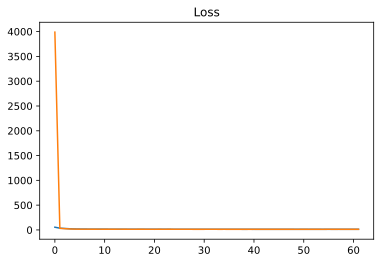

In [95]:
plt.title('Loss')
plt.plot(history.history['MAPE'], label='train')
plt.plot(history.history['val_MAPE'], label='test')
plt.show();

In [96]:
model.load_weights('../working/best_model.hdf5')
model.save('../working/nn_final.hdf5')

In [97]:
test_predict_nn3 = model.predict(test_dataset.batch(30))
print(f"TEST mape: {(mape(y_test, test_predict_nn3[:,0]))*100:0.2f}%")

TEST mape: 12.80%


TEST mape: 12.80%

In [100]:
sub_predict_nn3 = model.predict(sub_dataset.batch(30))
sample_submission['price'] = sub_predict_nn3[:,0]
sample_submission.to_csv('nn3_submission.csv', index=False)

### Fine tuning

In [101]:
# Посмотрим количесиво слоев в получившейся модели
print("Number of layers in the base model: ", len(model.layers))

Number of layers in the base model:  400


In [102]:
# Фиксируем половину слоев
model.trainable = True
half_layers = len(model.layers)//2
for layer in model.layers[:half_layers]:
  layer.trainable =  False

In [103]:
# adam = 0.0005
optimizer = tf.keras.optimizers.Adam(0.0005)
model.compile(loss='MAPE',optimizer=optimizer, metrics=['MAPE'])

In [104]:
checkpoint = ModelCheckpoint('../working/best_model.hdf5', monitor=['val_MAPE'], verbose=0, mode='min')
earlystop = EarlyStopping(monitor='val_MAPE', patience=10, restore_best_weights=True,)
callbacks_list = [checkpoint, earlystop]

In [105]:
history = model.fit(train_dataset.batch(30),
                    epochs=20,
                    validation_data = test_dataset.batch(30),
                    callbacks=callbacks_list
                   )

Epoch 1/20
190/190 [==============================] - 85s 446ms/step - loss: 12.4577 - MAPE: 12.4577 - val_loss: 12.5445 - val_MAPE: 12.5445
Epoch 2/20
190/190 [==============================] - 87s 458ms/step - loss: 12.2753 - MAPE: 12.2753 - val_loss: 12.4755 - val_MAPE: 12.4755
Epoch 3/20
190/190 [==============================] - 81s 428ms/step - loss: 12.0887 - MAPE: 12.0887 - val_loss: 12.4545 - val_MAPE: 12.4545
Epoch 4/20
190/190 [==============================] - 85s 448ms/step - loss: 12.1084 - MAPE: 12.1084 - val_loss: 12.4635 - val_MAPE: 12.4635
Epoch 5/20
190/190 [==============================] - 83s 435ms/step - loss: 12.1604 - MAPE: 12.1604 - val_loss: 12.4313 - val_MAPE: 12.4313
Epoch 6/20
190/190 [==============================] - 82s 432ms/step - loss: 12.0113 - MAPE: 12.0113 - val_loss: 12.4740 - val_MAPE: 12.4740
Epoch 7/20
190/190 [==============================] - 86s 455ms/step - loss: 12.0021 - MAPE: 12.0021 - val_loss: 12.4688 - val_MAPE: 12.4688
Epoch 8/20
19

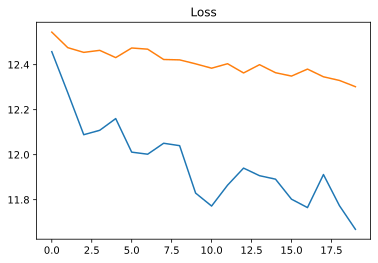

In [106]:
plt.title('Loss')
plt.plot(history.history['MAPE'], label='train')
plt.plot(history.history['val_MAPE'], label='test')
plt.show();

In [107]:
model.trainable = True
quad_layers = len(model.layers)//4
for layer in model.layers[:quad_layers]:
  layer.trainable =  False

In [108]:
optimizer = tf.keras.optimizers.Adam(0.0001)
model.compile(loss='MAPE',optimizer=optimizer, metrics=['MAPE'])

In [109]:
checkpoint = ModelCheckpoint('../working/best_model.hdf5', monitor=['val_MAPE'], verbose=0, mode='min')
earlystop = EarlyStopping(monitor='val_MAPE', patience=10, restore_best_weights=True,)
callbacks_list = [checkpoint, earlystop]

In [115]:
history = model.fit(train_dataset.batch(15),
                    epochs=25,
                    validation_data = test_dataset.batch(15),
                    callbacks=callbacks_list
                   )

Epoch 1/25
379/379 [==============================] - 114s 300ms/step - loss: 11.7532 - MAPE: 11.7532 - val_loss: 12.3021 - val_MAPE: 12.3021
Epoch 2/25
379/379 [==============================] - 109s 289ms/step - loss: 11.8788 - MAPE: 11.8788 - val_loss: 12.3111 - val_MAPE: 12.3111
Epoch 3/25
379/379 [==============================] - 108s 284ms/step - loss: 11.6059 - MAPE: 11.6059 - val_loss: 12.3065 - val_MAPE: 12.3065
Epoch 4/25
379/379 [==============================] - 109s 287ms/step - loss: 11.7438 - MAPE: 11.7438 - val_loss: 12.3027 - val_MAPE: 12.3027
Epoch 5/25
379/379 [==============================] - 103s 271ms/step - loss: 11.6184 - MAPE: 11.6184 - val_loss: 12.3078 - val_MAPE: 12.3078
Epoch 6/25
379/379 [==============================] - 104s 275ms/step - loss: 11.8149 - MAPE: 11.8149 - val_loss: 12.3180 - val_MAPE: 12.3180
Epoch 7/25
379/379 [==============================] - 108s 285ms/step - loss: 11.8246 - MAPE: 11.8246 - val_loss: 12.3086 - val_MAPE: 12.3086
Epoch 

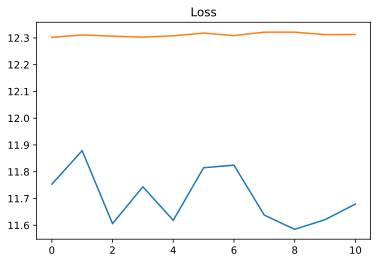

In [116]:
plt.title('Loss')
plt.plot(history.history['MAPE'], label='train')
plt.plot(history.history['val_MAPE'], label='test')
plt.show();

In [117]:
model.load_weights('../working/best_model.hdf5')
model.save('../working/nn_final.hdf5')

In [121]:
test_predict_nn3ft = model.predict(test_dataset.batch(30))
print(f"TEST mape: {(mape(y_test, test_predict_nn3[:,0]))*100:0.2f}%")

TEST mape: 12.31%


In [122]:
sub_predict_nn3ft = model.predict(sub_dataset.batch(30))
sample_submission['price'] = sub_predict_nn3ft[:,0]
sample_submission.to_csv('nn3ft_submission.csv', index=False)


#### Общие рекомендации:
* Попробовать разные архитектуры
* Провести более детальный анализ результатов
* Попробовать различные подходы в управление LR и оптимизаторы
* Поработать с таргетом
* Использовать Fine-tuning

#### Tabular
* В нейросеть желательно подавать данные с распределением, близким к нормальному, поэтому от некоторых числовых признаков имеет смысл взять логарифм перед нормализацией. Пример:
`modelDateNorm = np.log(2020 - data['modelDate'])`
Статья по теме: https://habr.com/ru/company/ods/blog/325422

* Извлечение числовых значений из текста:
Парсинг признаков 'engineDisplacement', 'enginePower', 'Владение' для извлечения числовых значений.

* Cокращение размерности категориальных признаков
Признак name 'name' содержит данные, которые уже есть в других столбцах ('enginePower', 'engineDisplacement', 'vehicleTransmission'). Можно удалить эти данные. Затем можно еще сильнее сократить размерность, например выделив наличие xDrive в качестве отдельного признака.

* Поработать над Feature engineering



#### NLP
* Выделить из описаний часто встречающиеся блоки текста, заменив их на кодовые слова или удалив
* Сделать предобработку текста, например сделать лемматизацию - алгоритм ставящий все слова в форму по умолчанию (глаголы в инфинитив и т. д.), чтобы токенайзер не преобразовывал разные формы слова в разные числа
Статья по теме: https://habr.com/ru/company/Voximplant/blog/446738/
* Поработать над алгоритмами очистки и аугментации текста



#### CV
* Попробовать различные аугментации
* Fine-tuning

# Blend

In [123]:
blend_predict = (test_predict_catboost + test_predict_nn3ft[:,0]) / 2
print(f"TEST mape: {(mape(y_test, blend_predict))*100:0.2f}%")

TEST mape: 11.44%


TEST mape: 20.89% # default

In [124]:
blend_sub_predict = (sub_predict_catboost + sub_predict_nn3ft[:,0]) / 2
sample_submission['price'] = blend_sub_predict
sample_submission.to_csv('blend_submission.csv', index=False)

# Model Bonus: проброс признака

In [125]:
# MLP
model_mlp = Sequential()
model_mlp.add(L.Dense(512, input_dim=X_train.shape[1], activation="relu"))
model_mlp.add(L.Dropout(0.5))
model_mlp.add(L.Dense(256, activation="relu"))
model_mlp.add(L.Dropout(0.5))

In [126]:
# FEATURE Input
# Iput
productiondate = L.Input(shape=[1], name="productiondate")
# Embeddings layers
emb_productiondate = L.Embedding(len(X.productionDate.unique().tolist())+1, 20)(productiondate)
f_productiondate = L.Flatten()(emb_productiondate)

In [127]:
combinedInput = L.concatenate([model_mlp.output, f_productiondate,])
# being our regression head
head = L.Dense(64, activation="relu")(combinedInput)
head = L.Dense(1, activation="linear")(head)

model = Model(inputs=[model_mlp.input, productiondate], outputs=head)

In [128]:
model.summary()

Model: "functional_9"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
dense_20_input (InputLayer)     [(None, 183)]        0                                            
__________________________________________________________________________________________________
dense_20 (Dense)                (None, 512)          94208       dense_20_input[0][0]             
__________________________________________________________________________________________________
dropout_15 (Dropout)            (None, 512)          0           dense_20[0][0]                   
__________________________________________________________________________________________________
productiondate (InputLayer)     [(None, 1)]          0                                            
_______________________________________________________________________________________

In [129]:
optimizer = tf.keras.optimizers.Adam(0.01)
model.compile(loss='MAPE',optimizer=optimizer, metrics=['MAPE'])

In [130]:
history = model.fit([X_train, X_train.productionDate.values], y_train,
                    batch_size=512,
                    epochs=500, # фактически мы обучаем пока EarlyStopping не остановит обучение
                    validation_data=([X_test, X_test.productionDate.values], y_test),
                    callbacks=callbacks_list
                   )

Epoch 1/500
12/12 [==============================] - 0s 20ms/step - loss: 99.9810 - MAPE: 99.9810 - val_loss: 99.7817 - val_MAPE: 99.7817
Epoch 2/500
12/12 [==============================] - 0s 7ms/step - loss: 98.1957 - MAPE: 98.1957 - val_loss: 92.1560 - val_MAPE: 92.1560
Epoch 3/500
12/12 [==============================] - 0s 7ms/step - loss: 75.7757 - MAPE: 75.7757 - val_loss: 50.8328 - val_MAPE: 50.8328
Epoch 4/500
12/12 [==============================] - 0s 7ms/step - loss: 53.6643 - MAPE: 53.6643 - val_loss: 48.4967 - val_MAPE: 48.4967
Epoch 5/500
12/12 [==============================] - 0s 7ms/step - loss: 49.3766 - MAPE: 49.3766 - val_loss: 46.3104 - val_MAPE: 46.3104
Epoch 6/500
12/12 [==============================] - 0s 7ms/step - loss: 45.5052 - MAPE: 45.5052 - val_loss: 43.5554 - val_MAPE: 43.5554
Epoch 7/500
12/12 [==============================] - 0s 7ms/step - loss: 42.9074 - MAPE: 42.9074 - val_loss: 41.0792 - val_MAPE: 41.0792
Epoch 8/500
12/12 [=====================

In [131]:
model.load_weights('../working/best_model.hdf5')
test_predict_nn_bonus = model.predict([X_test, X_test.productionDate.values])
print(f"TEST mape: {(mape(y_test, test_predict_nn_bonus[:,0]))*100:0.2f}%")

TEST mape: 13.72%


TEST mape: 13.14%

In [ ]:
# 